# Facial Keypoints Detection
Detecting the location of keypoints on face images using Deep Learning

https://www.kaggle.com/c/facial-keypoints-detection

In [1]:
workdir = "/home/ubuntu/kaggle/facialKeypoints/data/"
FTRAIN = workdir + 'training.csv'
FTEST = workdir + 'test.csv'

In [2]:
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

## Loading Data

In [3]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [4]:
#Using Lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GRID K520 (CNMeM is disabled)


## First model: a single hidden layer

In [ ]:
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=1500,  # we want to train this many epochs
    verbose=1,
    )

X, y = load()
net1.fit(X, y)

#Will take about 3 min

In [6]:
##Error measure: RMSE
#Minimum MSE on validation
import numpy as np
np.sqrt(0.00271) * 48

2.498767696285511

Testing it out

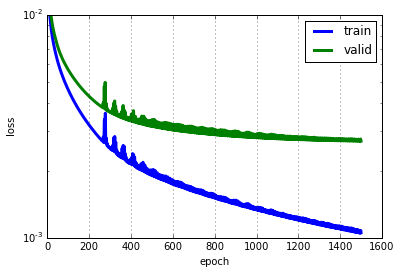

In [7]:
#Learning curves
%matplotlib inline
import matplotlib.pyplot as pyplot
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

How do the net's predictions look like, then? Let's pick a few examples from the test set and check

In [ ]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

pyplot.show()

## Second model: convolutions

In [8]:
#A function load2d that wraps the previously written load and does the necessary transformations
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [ ]:
#We'll build a convolutional neural net with three convolutional layers and two fully connected layers. 
#Each conv layer is followed by a 2x2 max-pooling layer. 
#Starting with 32 filters, we double the number of filters with every conv layer. The densely connected hidden layers both have 500 units
net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=1500,
    verbose=1,
    )

X, y = load2d()  # load 2-d data

# Training for 1500 epochs will take a while. (About 48 minutes)
net2.fit(X, y)


In [11]:
np.sqrt(0.00147) * 48
#RMSE = 1.84
#The RMSE is about 26% better than the 2.5 of the net1, but took a lot more to train (16 times more)

1.8403477932173582

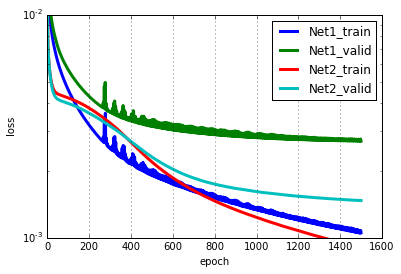

In [12]:
#Learning curves
%matplotlib inline
import matplotlib.pyplot as pyplot
train_loss1 = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss1 = np.array([i["valid_loss"] for i in net1.train_history_])
train_loss2 = np.array([i["train_loss"] for i in net2.train_history_])
valid_loss2 = np.array([i["valid_loss"] for i in net2.train_history_])
pyplot.plot(train_loss1, linewidth=3, label="Net1_train")
pyplot.plot(valid_loss1, linewidth=3, label="Net1_valid")
pyplot.plot(train_loss2, linewidth=3, label="Net2_train")
pyplot.plot(valid_loss2, linewidth=3, label="Net2_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

We can compare the predictions of the two networks using one of the more problematic samples in the test set

In [ ]:
%matplotlib inline
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = pyplot.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
pyplot.show()

### Improving training time

we'll do a combination of two tricks to make the net train faster:
1. starting with a higher learning rate and decreasing it during the course of training
2. increasing the optimization method's momentum parameter during training.

In [13]:
#before we can assign new values to update_learning_rate and update_momentum on the fly, we'll have to change these two parameters to become Theano shared variables.

import theano

def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [ ]:
#NeuralNet allows us to update parameters during training using the on_epoch_finished hook. 
#We can pass a function to on_epoch_finished and it'll be called whenever an epoch is finished.

net3 = NeuralNet(
    
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    
    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    
    regression=True,
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    
    max_epochs=1500,
    verbose=1,
    
    )

X, y = load2d()
net3.fit(X, y)


In [15]:
np.sqrt(0.00123) * 48
#RMSE = 1.68
#About 10% better than the 1.84 of net2, and took the same time to train

1.6834250800080175

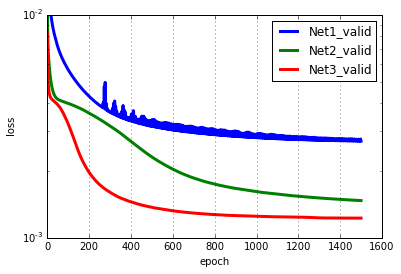

In [16]:
#Learning curves
%matplotlib inline
import matplotlib.pyplot as pyplot
valid_loss1 = np.array([i["valid_loss"] for i in net1.train_history_])
valid_loss2 = np.array([i["valid_loss"] for i in net2.train_history_])
valid_loss3 = np.array([i["valid_loss"] for i in net3.train_history_])
pyplot.plot(valid_loss1, linewidth=3, label="Net1_valid")
pyplot.plot(valid_loss2, linewidth=3, label="Net2_valid")
pyplot.plot(valid_loss3, linewidth=3, label="Net3_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()